In [1]:
#!pip -q install einops
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
from set_data import load_real_weather, WeatherPairs, split_windows_train_val_test
from visualization import (plot_complete_data, 
                           plot_weatherpair_panel,
                           visualize_loss, plot_ctx_and_scenarios_panel)
from utils import *
from diffusion_model import DiffusionSchedule, TinyCondUNet1D
from diffusion_model_train import train_one_epoch, eval_epoch, EarlyStopping
from diffusion_model_generate import p_sample_loop
import error_metrics as em
np.set_printoptions(suppress=True)

VARS = 6
EPOCHS = 100
feature_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)



device: cpu


In [2]:

X, columns = load_real_weather("../../data/data_20150630_to_20250630.csv", 
                      start_date="2015-06-30", end_date="2024-06-30")
print("Real data shape:", X.shape)  # (days, number of features)


Real data shape: (3289, 6)


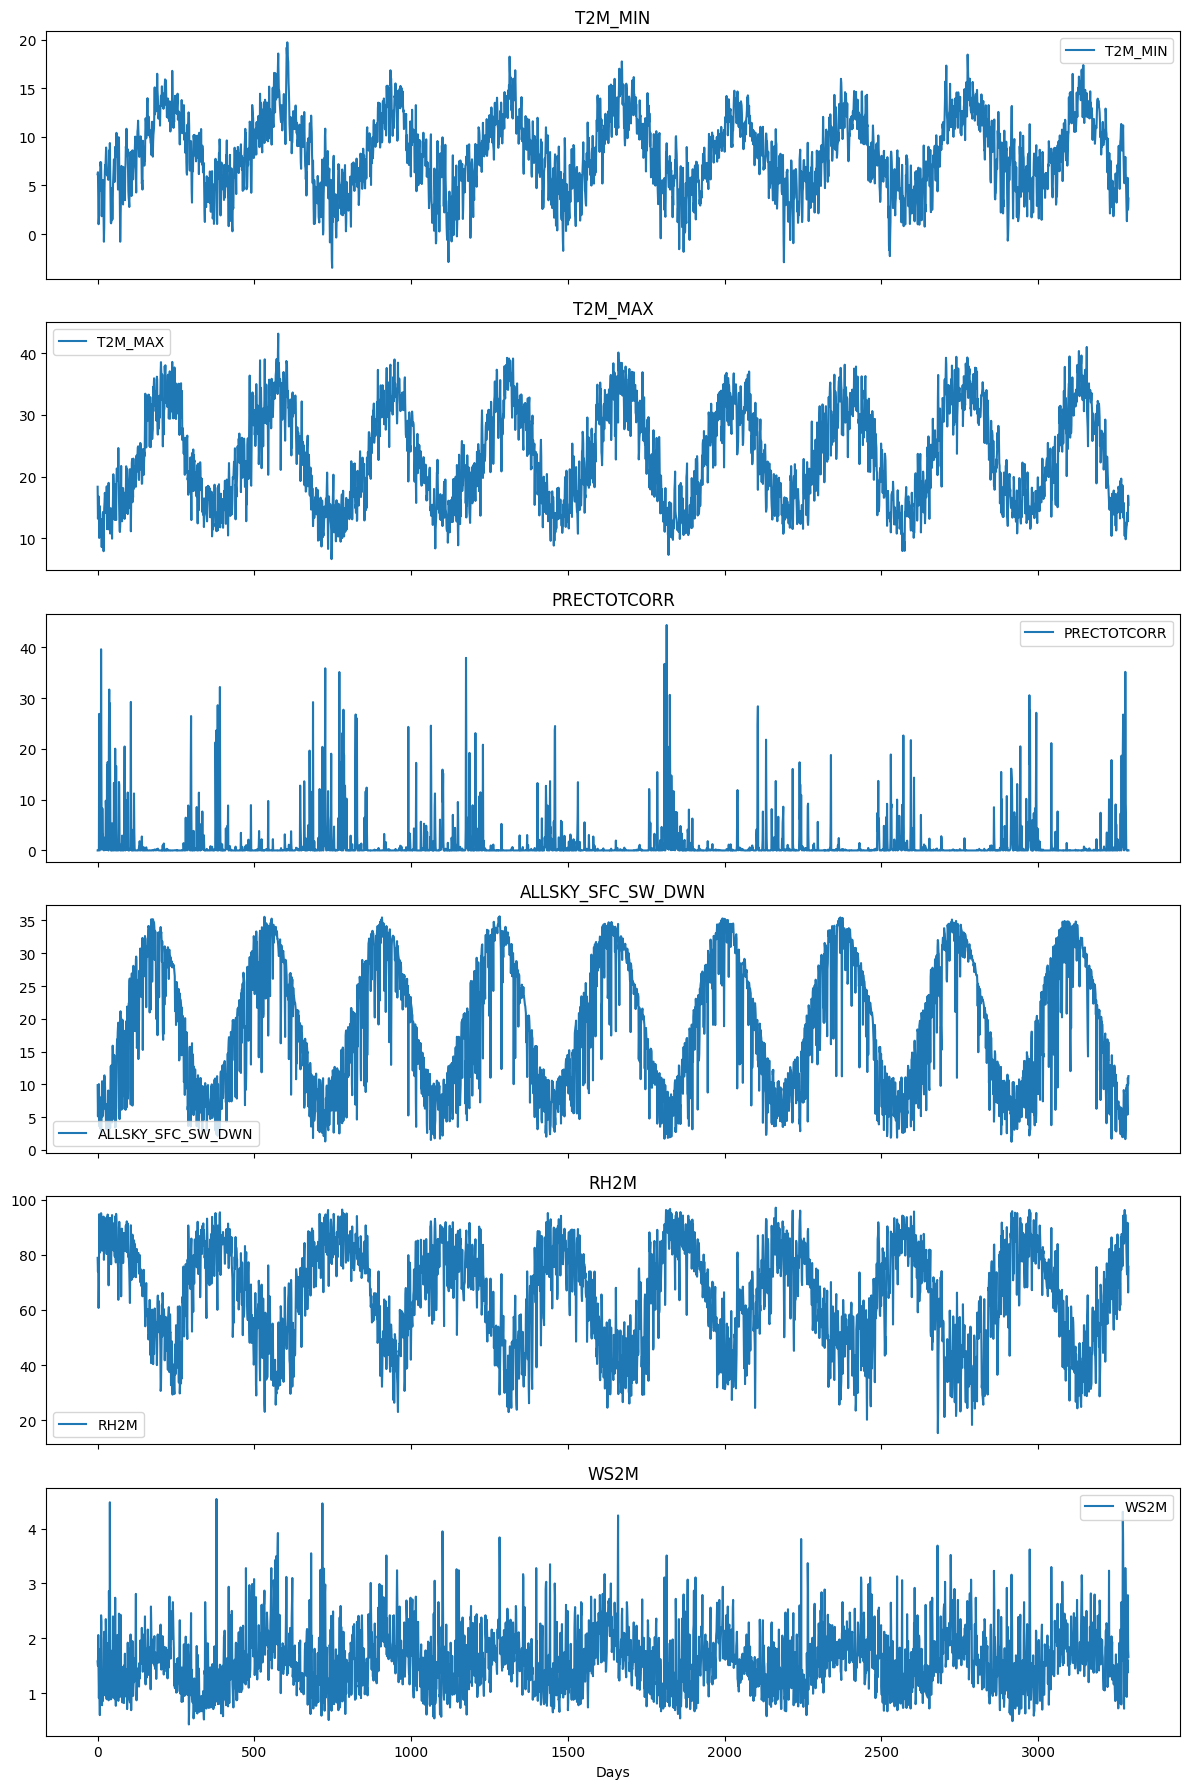

In [3]:
plot_complete_data(X, columns)

In [4]:
X

array([[ 6.15      , 18.37      ,  0.        ,  9.87      , 78.87      ,
         1.58      ],
       [ 6.36      , 13.2       ,  0.        ,  5.11      , 73.86      ,
         1.5       ],
       [ 3.34      , 14.74      ,  0.01      ,  9.41      , 78.97      ,
         2.06      ],
       ...,
       [ 2.5       , 12.764286  ,  0.        , 10.998571  , 74.987144  ,
         2.7871428 ],
       [ 2.6557143 , 16.928572  ,  0.        , 10.004286  , 66.34286   ,
         1.7857143 ],
       [ 3.672857  , 15.43      ,  0.00571429, 11.26      , 75.69143   ,
         1.6628572 ]], shape=(3289, 6), dtype=float32)

In [5]:
CTX = 120
HORIZON = 60
dataset = WeatherPairs(X, ctx=CTX, horizon=HORIZON, stride=1)
train_ds, val_ds, test_ds = split_windows_train_val_test(dataset, test_frac=0.1, val_frac=0.1, train_frac=0.8)



In [33]:
train_ds.indices

array([   0,    1,    2, ..., 2125, 2126, 2127], shape=(2128,))

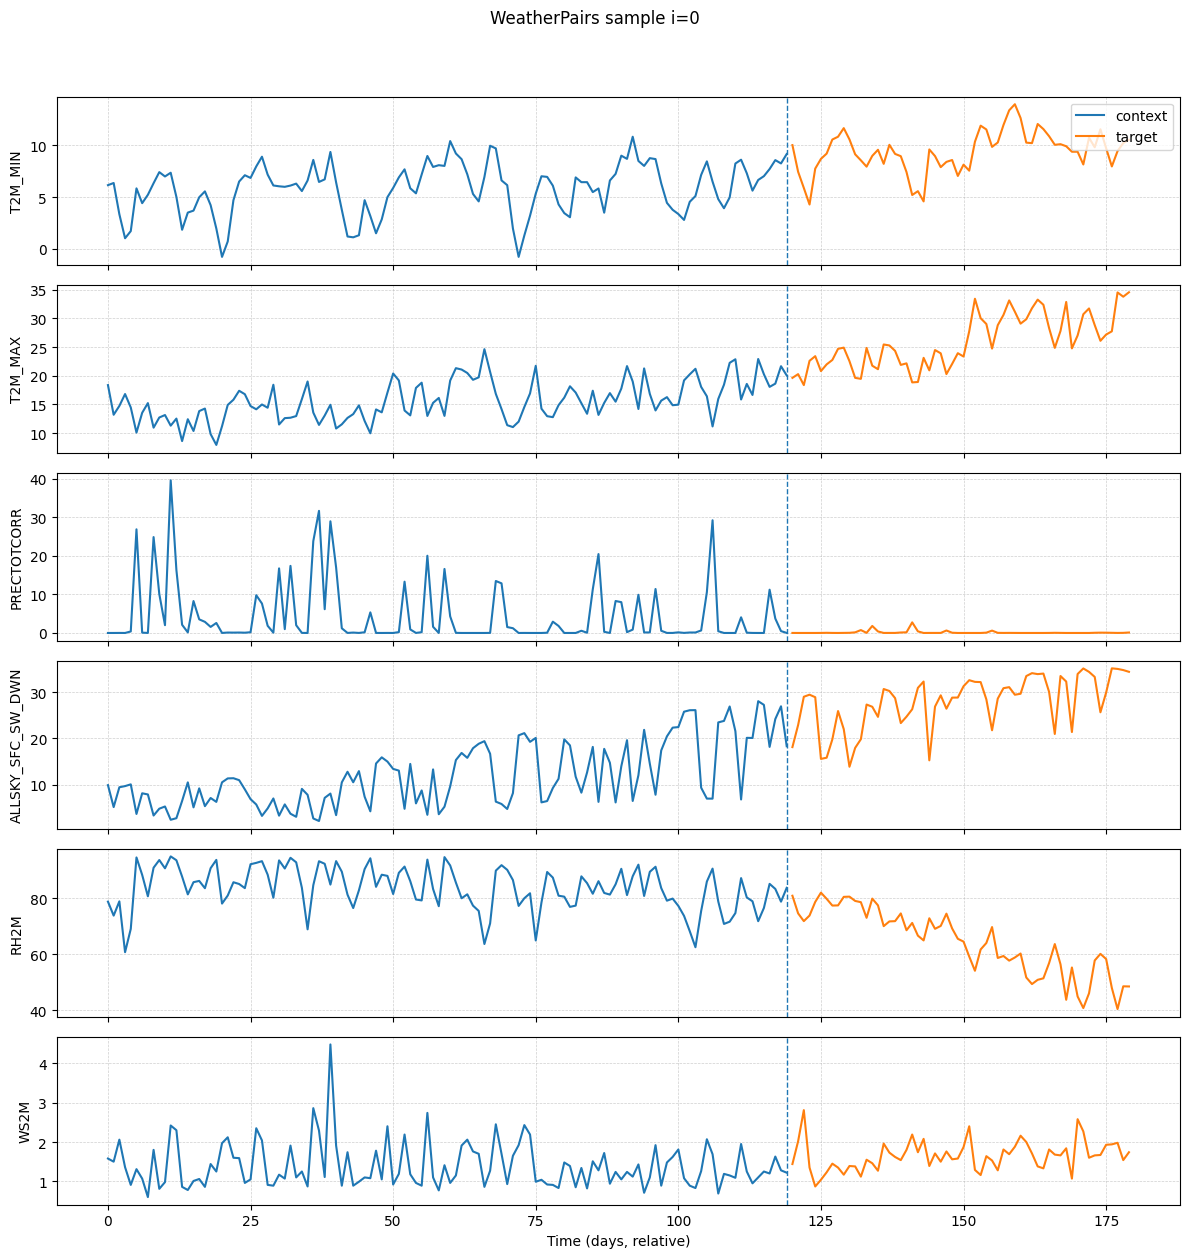

In [7]:
plot_weatherpair_panel(train_ds, i=0, feature_names=feature_names)

In [8]:
print("windows:", len(dataset))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False)


windows: 3110
train/val/test: 2128 311 311


In [9]:
mean, std = fit_standardizer(train_ds)
mean_t = torch.tensor(mean, device=device)
std_t = torch.tensor(std, device=device)
print("mean:", mean, "\nstd:", std)

mean: [ 8.391046  23.335665   1.238991  18.92669   65.676414   1.5851189] 
std: [ 3.8024783  7.7259035  4.057641   9.8367195 17.69659    0.5605637]


In [10]:
sched = DiffusionSchedule(T=250)

In [11]:
model = TinyCondUNet1D(in_vars=VARS, ctx_vars=VARS).to(device)


epoch 01 | train 0.7000 | val 0.4623 | best inf (bad 0/20)
epoch 02 | train 0.4296 | val 0.3851 | best 0.4623 (bad 0/20)
epoch 03 | train 0.3897 | val 0.3623 | best 0.3851 (bad 0/20)
epoch 04 | train 0.3644 | val 0.3771 | best 0.3623 (bad 0/20)
epoch 05 | train 0.3472 | val 0.3388 | best 0.3623 (bad 1/20)
epoch 06 | train 0.3502 | val 0.3454 | best 0.3388 (bad 0/20)
epoch 07 | train 0.3510 | val 0.3529 | best 0.3388 (bad 1/20)
epoch 08 | train 0.3512 | val 0.3597 | best 0.3388 (bad 2/20)
epoch 09 | train 0.3433 | val 0.3402 | best 0.3388 (bad 3/20)
epoch 10 | train 0.3381 | val 0.3697 | best 0.3388 (bad 4/20)
epoch 11 | train 0.3352 | val 0.3301 | best 0.3388 (bad 5/20)
epoch 12 | train 0.3262 | val 0.3467 | best 0.3301 (bad 0/20)
epoch 13 | train 0.3283 | val 0.3497 | best 0.3301 (bad 1/20)
epoch 14 | train 0.3229 | val 0.3150 | best 0.3301 (bad 2/20)
epoch 15 | train 0.3279 | val 0.3256 | best 0.3150 (bad 0/20)
epoch 16 | train 0.3197 | val 0.3257 | best 0.3150 (bad 1/20)
epoch 17 | 

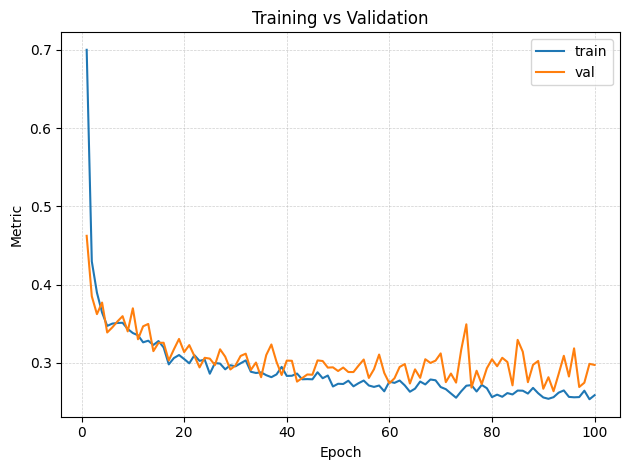

In [12]:
#opt = torch.optim.RMSprop(model.parameters(), lr=2e-4)
opt = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4,
    nesterov=True
)

train_hist, val_hist = [], []

early = EarlyStopping(patience=20, min_delta=1e-4, mode="min")

for e in range(1, EPOCHS + 1):
    tr = train_one_epoch(opt, model, sched, device, train_loader, mean_t, std_t)
    va = eval_epoch(model, device, val_loader, sched, mean_t, std_t)

    train_hist.append(float(tr))
    val_hist.append(float(va))

    print(f"epoch {e:02d} | train {tr:.4f} | val {va:.4f} | best {early.best:.4f} (bad {early.num_bad}/{early.patience})")

    if early.step(va, model, e):
        print(f"Early stopping at epoch {e:02d}. Best val={early.best:.4f} at epoch {early.best_epoch:02d}.")
        break

# restore best weights before final eval / saving
early.restore_best(model)

visualize_loss(len(train_hist), train_hist, val_hist)



In [13]:
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,60,6)
tgt_raw = tgt_raw.numpy()       # (60,6)

scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS, 
                      mean_t, std_t, n_scenarios=50).numpy() 
days = np.arange(HORIZON)


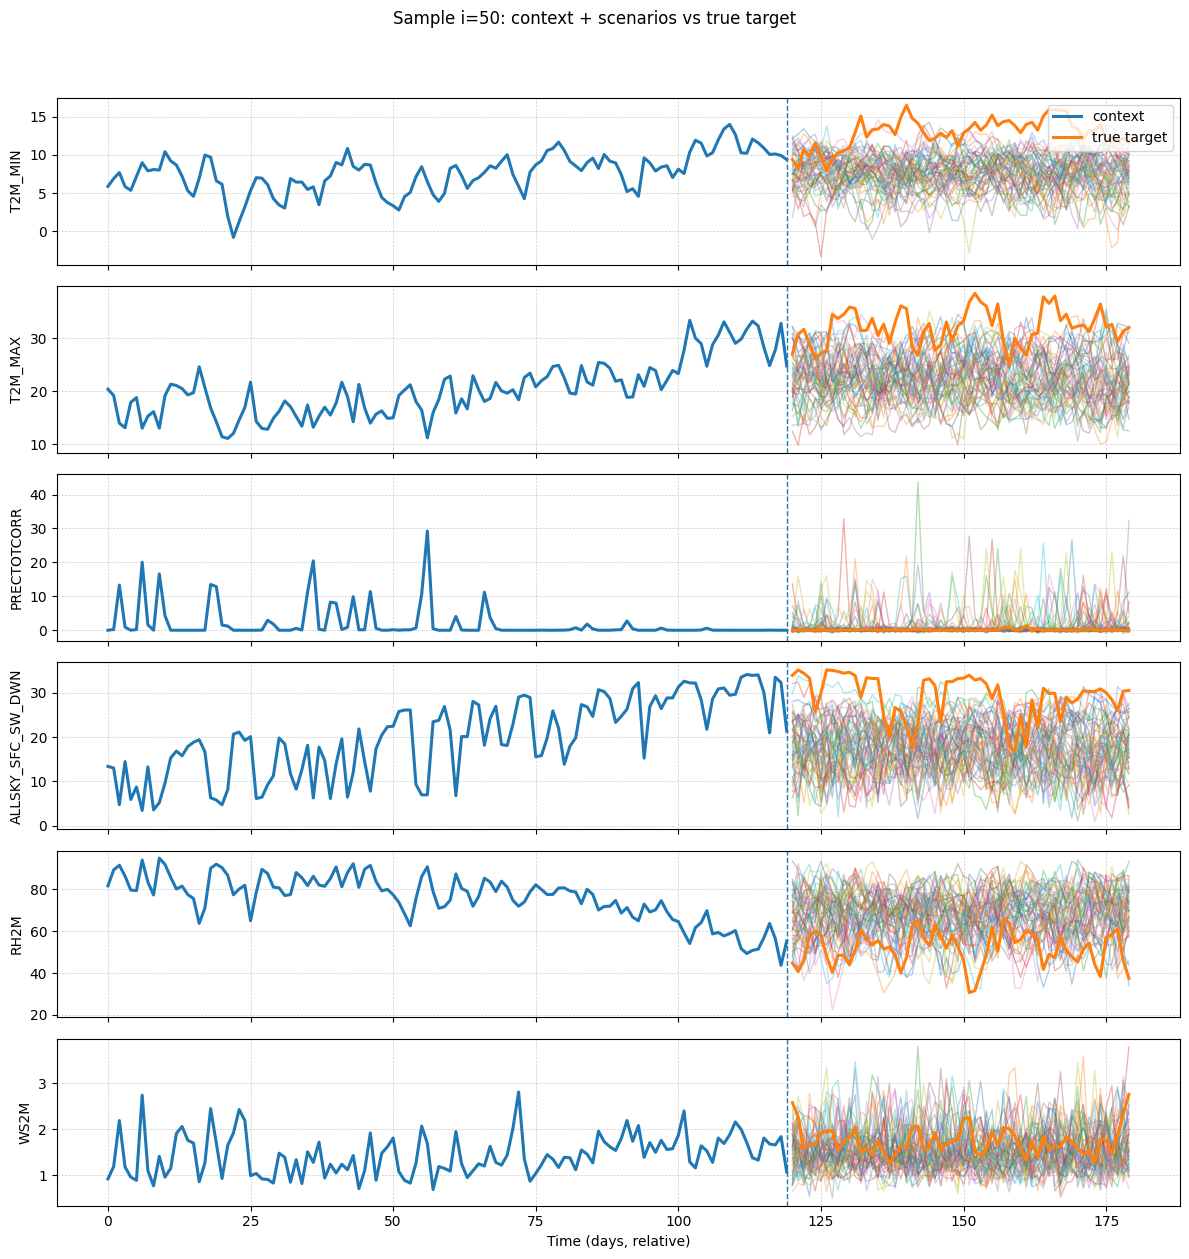

In [14]:
# Get one validation sample
ctx_raw, tgt_raw = val_ds[0]
pd.DataFrame(ctx_raw).to_csv('fixed_window.csv')
ctx_raw = ctx_raw.unsqueeze(0)  # (1,CTX,VARS)

# Generate scenarios: (n_scenarios, HORIZON, VARS)
scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS,
                      mean_t, std_t, n_scenarios=50).detach().cpu().numpy()

plot_ctx_and_scenarios_panel(
    dataset,
    50,
    scens,
    feature_names=feature_names,
    max_scen_to_plot=100
)


In [15]:
np.save("scenarios.npy", scens)

In [16]:
Omega = np.load("scenarios.npy")
Omega

array([[[ 6.4224434 , 19.992437  ,  1.0064651 , 15.815281  ,
         78.5917    ,  1.6716895 ],
        [ 8.829495  , 20.457533  , -0.4742849 , 13.9657135 ,
         80.904655  ,  1.0332576 ],
        [ 8.385547  , 20.316406  ,  0.8405063 , 12.059502  ,
         81.65258   ,  1.1500483 ],
        ...,
        [10.8418255 , 32.53572   ,  0.9063463 , 25.330372  ,
         37.660915  ,  2.3094208 ],
        [10.712436  , 31.026638  ,  0.40143448, 25.663355  ,
         42.089108  ,  2.1330733 ],
        [10.986317  , 31.066076  ,  0.7845942 , 26.33923   ,
         45.81066   ,  1.2315582 ]],

       [[ 7.622785  , 20.359821  , -0.56386125, 13.558939  ,
         76.94561   ,  1.7539473 ],
        [ 6.7827005 , 22.122248  , -0.20538771, 14.519719  ,
         73.62722   ,  1.1592059 ],
        [ 7.033516  , 24.46785   , -0.16325772, 12.993851  ,
         68.732895  ,  1.3083458 ],
        ...,
        [ 4.2721205 , 15.633157  ,  0.03320634, 10.582977  ,
         85.01828   ,  0.7508661 ],
  

In [17]:
# pick a test sample
i = 0
ctx, tgt = test_ds[i]     # torch tensors

# move to numpy
y = tgt.detach().cpu().numpy()   # shape: (H, D)
# inverse transform (broadcasting works)

In [18]:
y

array([[ 4.49, 14.23,  1.12, 10.33, 82.97,  0.88],
       [ 1.61, 13.77,  0.  ,  5.14, 70.75,  1.36],
       [ 5.  , 14.41,  0.  ,  6.11, 74.97,  1.16],
       [ 7.19, 19.96,  0.01, 10.34, 74.25,  0.99],
       [ 9.22, 19.25,  0.85,  8.57, 73.26,  1.18],
       [ 9.77, 13.83,  7.52,  3.07, 93.37,  1.55],
       [ 5.75, 16.1 ,  0.14,  6.4 , 85.72,  0.79],
       [ 5.39, 13.77,  2.05,  3.38, 95.26,  1.55],
       [ 7.4 , 13.43,  1.33,  4.47, 92.47,  0.72],
       [ 4.39, 14.28,  0.2 ,  7.54, 88.61,  0.95],
       [ 4.49, 12.75,  6.56,  3.73, 84.82,  1.69],
       [ 6.89, 12.68,  6.24,  3.38, 90.8 ,  1.63],
       [ 3.76, 14.51,  0.03,  8.67, 85.97,  1.08],
       [ 1.75, 17.77,  0.  ,  9.77, 65.51,  1.27],
       [ 4.12, 10.82, 13.07,  3.17, 95.14,  1.11],
       [ 4.83, 12.56,  1.21,  6.65, 85.25,  0.77],
       [ 2.36, 14.49,  0.  ,  9.22, 72.31,  1.3 ],
       [ 1.33, 14.53,  0.03,  5.9 , 79.84,  1.81],
       [ 1.56, 13.36,  0.01,  9.47, 74.57,  2.39],
       [ 1.76, 14.54,  0.  ,  6

In [19]:
Omega.shape

(50, 60, 6)

In [20]:

mse  = em.mse_ensemble_mean_batch(Omega, y)
mae = em.mae_ensemble_mean_batch(Omega, y)

#print(f"MSE  : {mse:.4f}")
#print(f"MAPE : {mape:.2f}%")
#print(f"CRPS : {crps:.4f}")
mse


yhat: [ 8.024465  23.034752   1.0599842 18.725374  66.69125    1.5468156]


array([ 10.175678  ,  55.985363  ,  44.925686  , 106.844345  ,
       284.26672   ,   0.38359278], dtype=float32)

In [21]:
mae

array([ 2.6951773 ,  7.031928  ,  3.1535254 ,  9.566236  , 14.945265  ,
        0.49714127], dtype=float32)

In [22]:
var_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]
crps_nd = em.crps_ensemble_snd(Omega, y, average=False)  # (60, 6)
crps_per_var = crps_nd.mean(axis=0)  # (6,)
for name, val in zip(var_names, crps_per_var):
    print(name, val)


T2M_MIN 1.9544656
T2M_MAX 4.916819
PRECTOTCORR 2.6856055
ALLSKY_SFC_SW_DWN 6.853107
RH2M 10.362194
WS2M 0.34881592


In [23]:
y.shape

(60, 6)

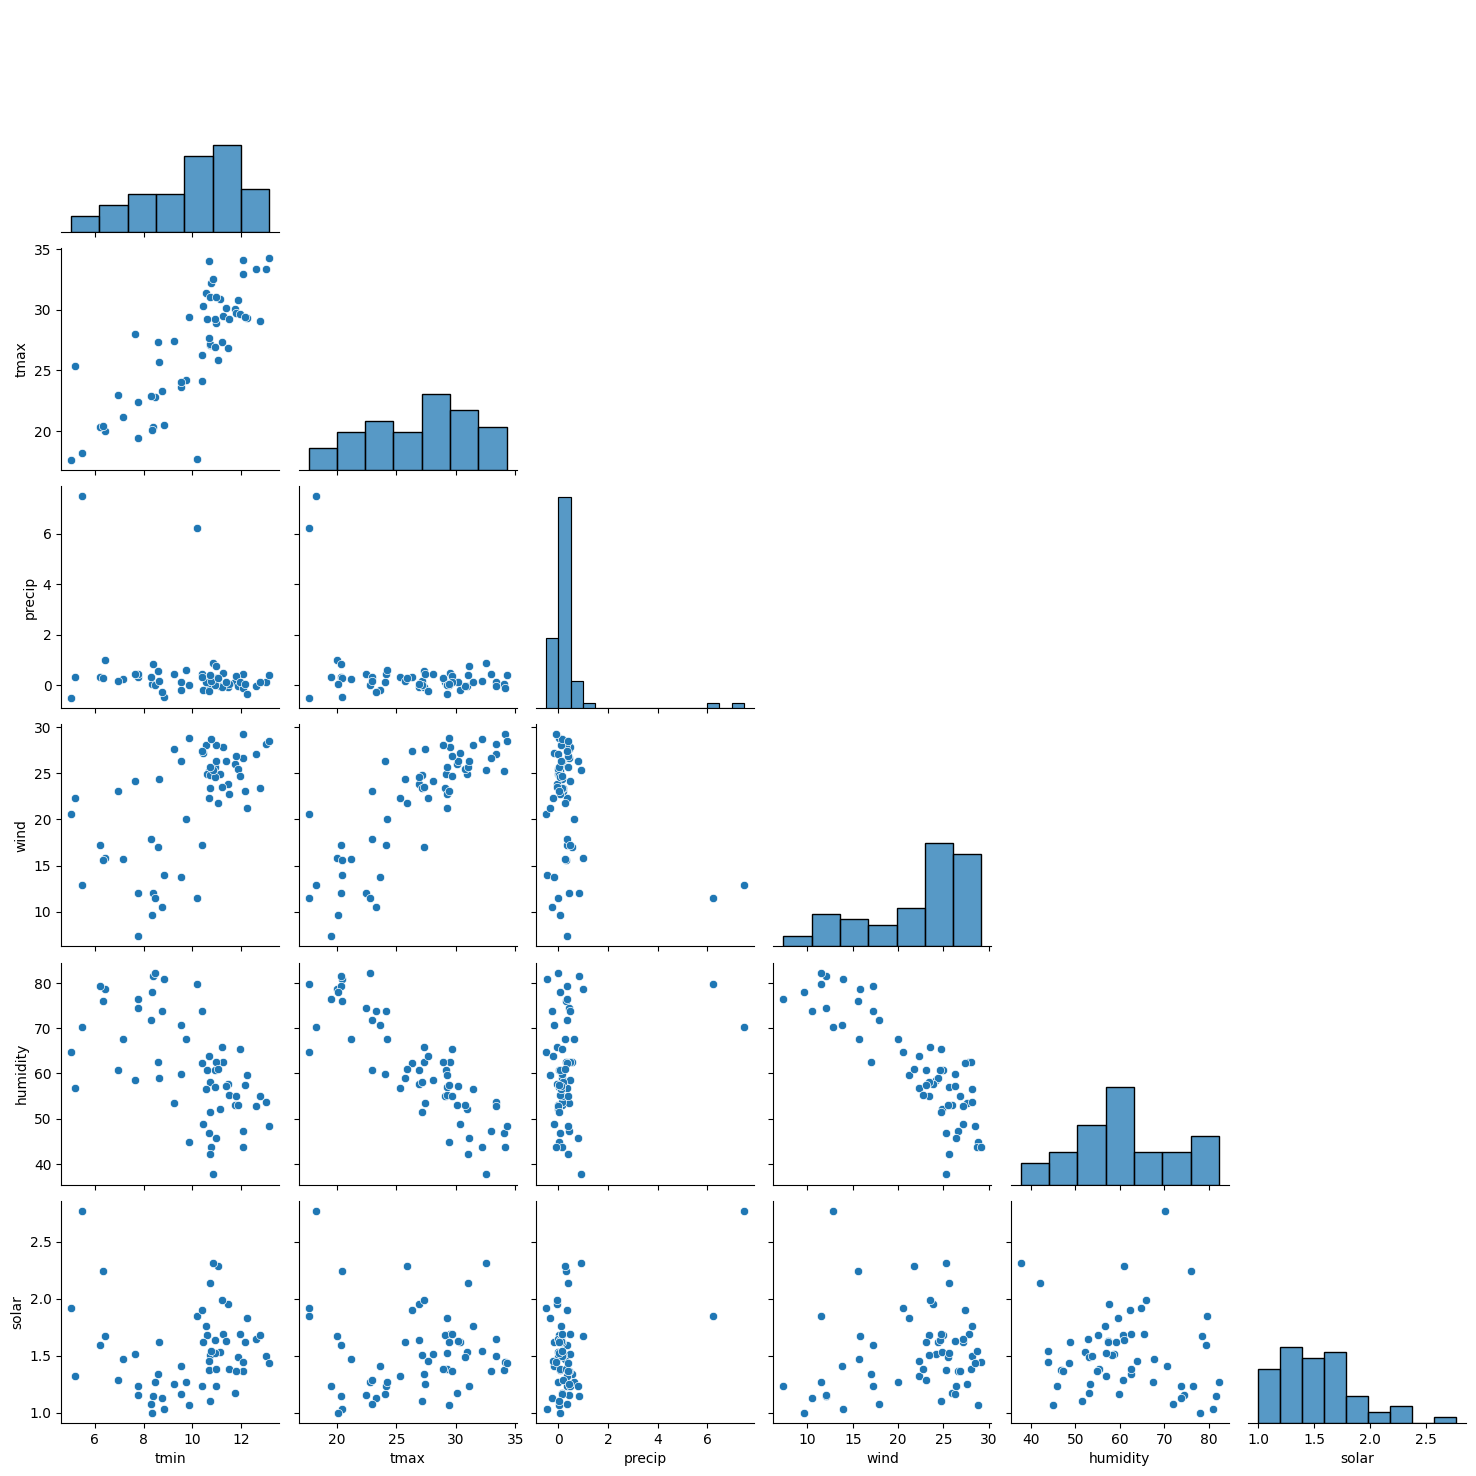

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

var_names = ["tmin", "tmax", "precip", "wind", "humidity", "solar"]

#X_mean = Omega.mean(axis=0)   # (60, 6)
X_mean = Omega[0]   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

In [25]:
y.shape

(60, 6)

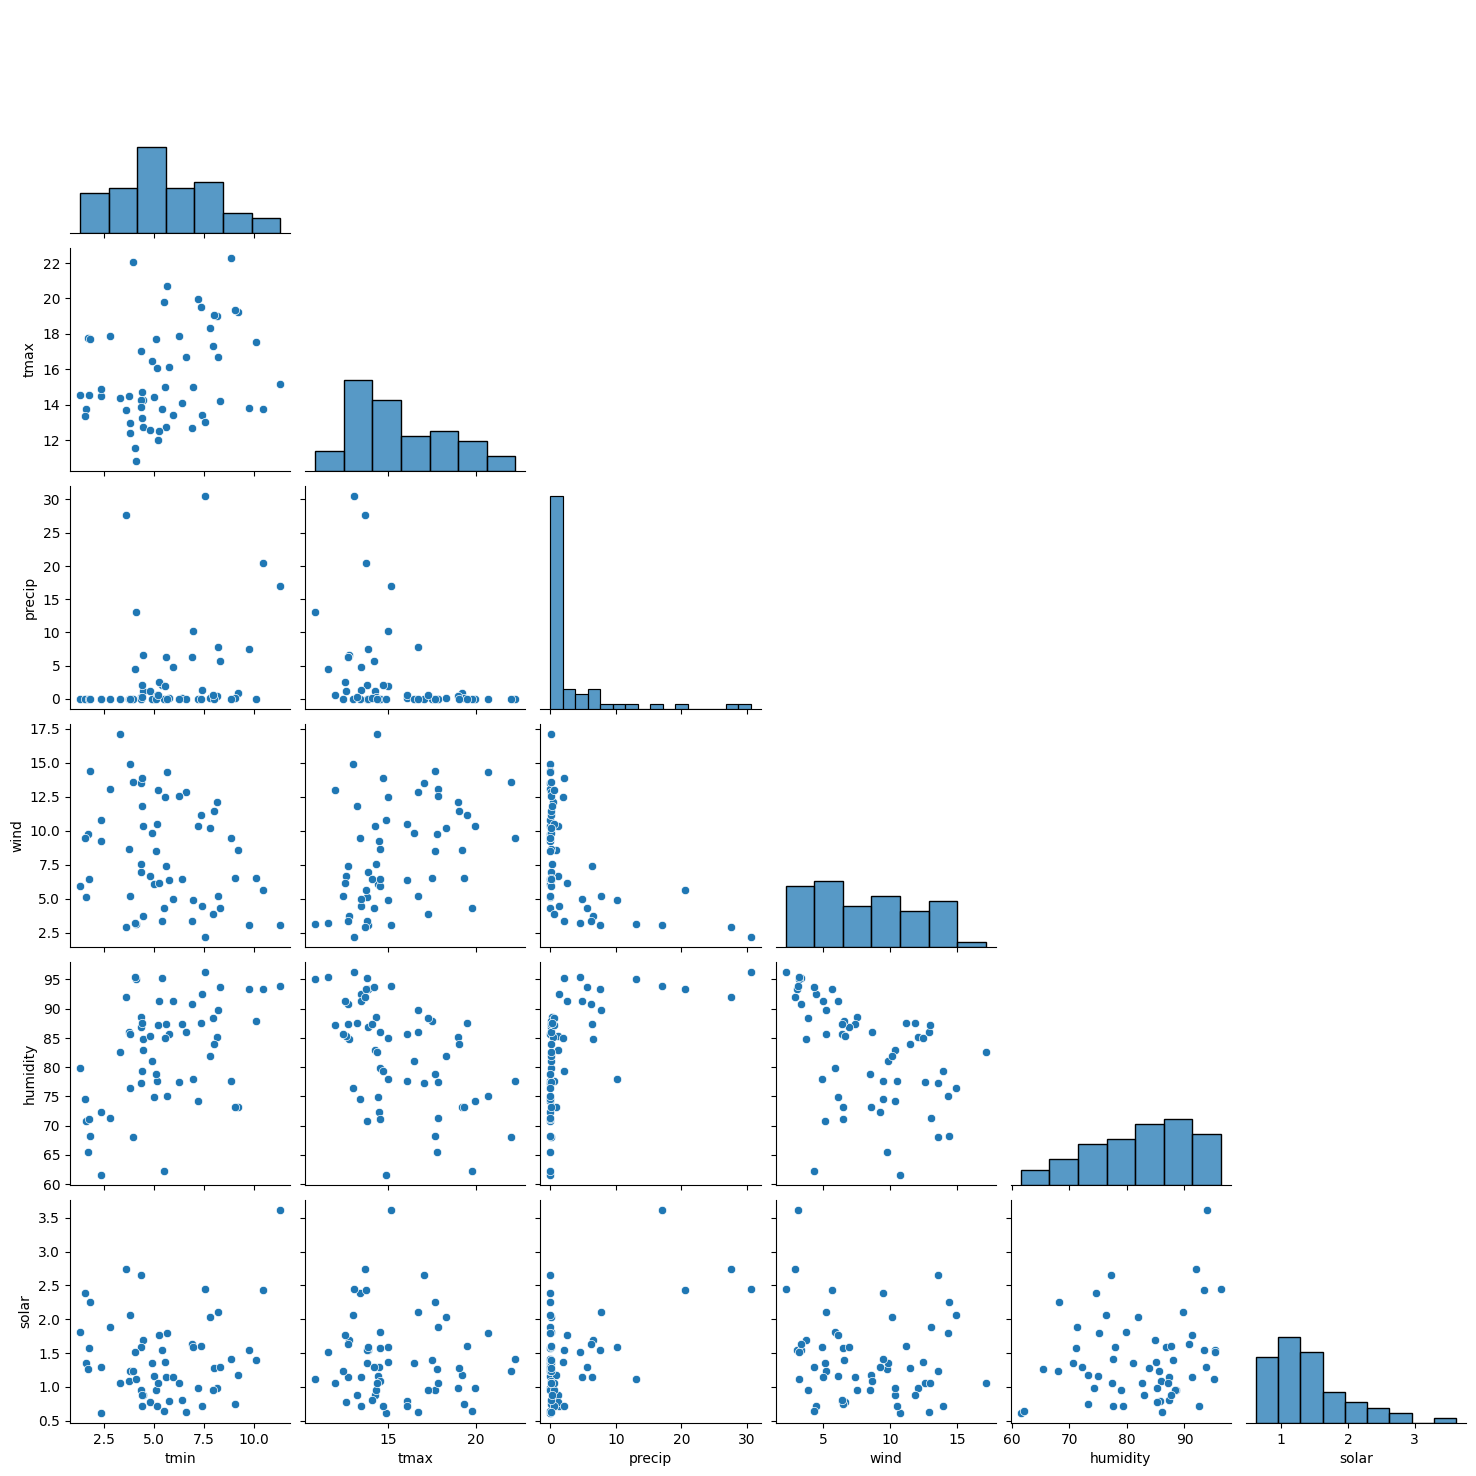

In [26]:
#X_mean = Omega.mean(axis=0)   # (60, 6)
X_mean = y   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

In [27]:
Omega.shape

(50, 60, 6)

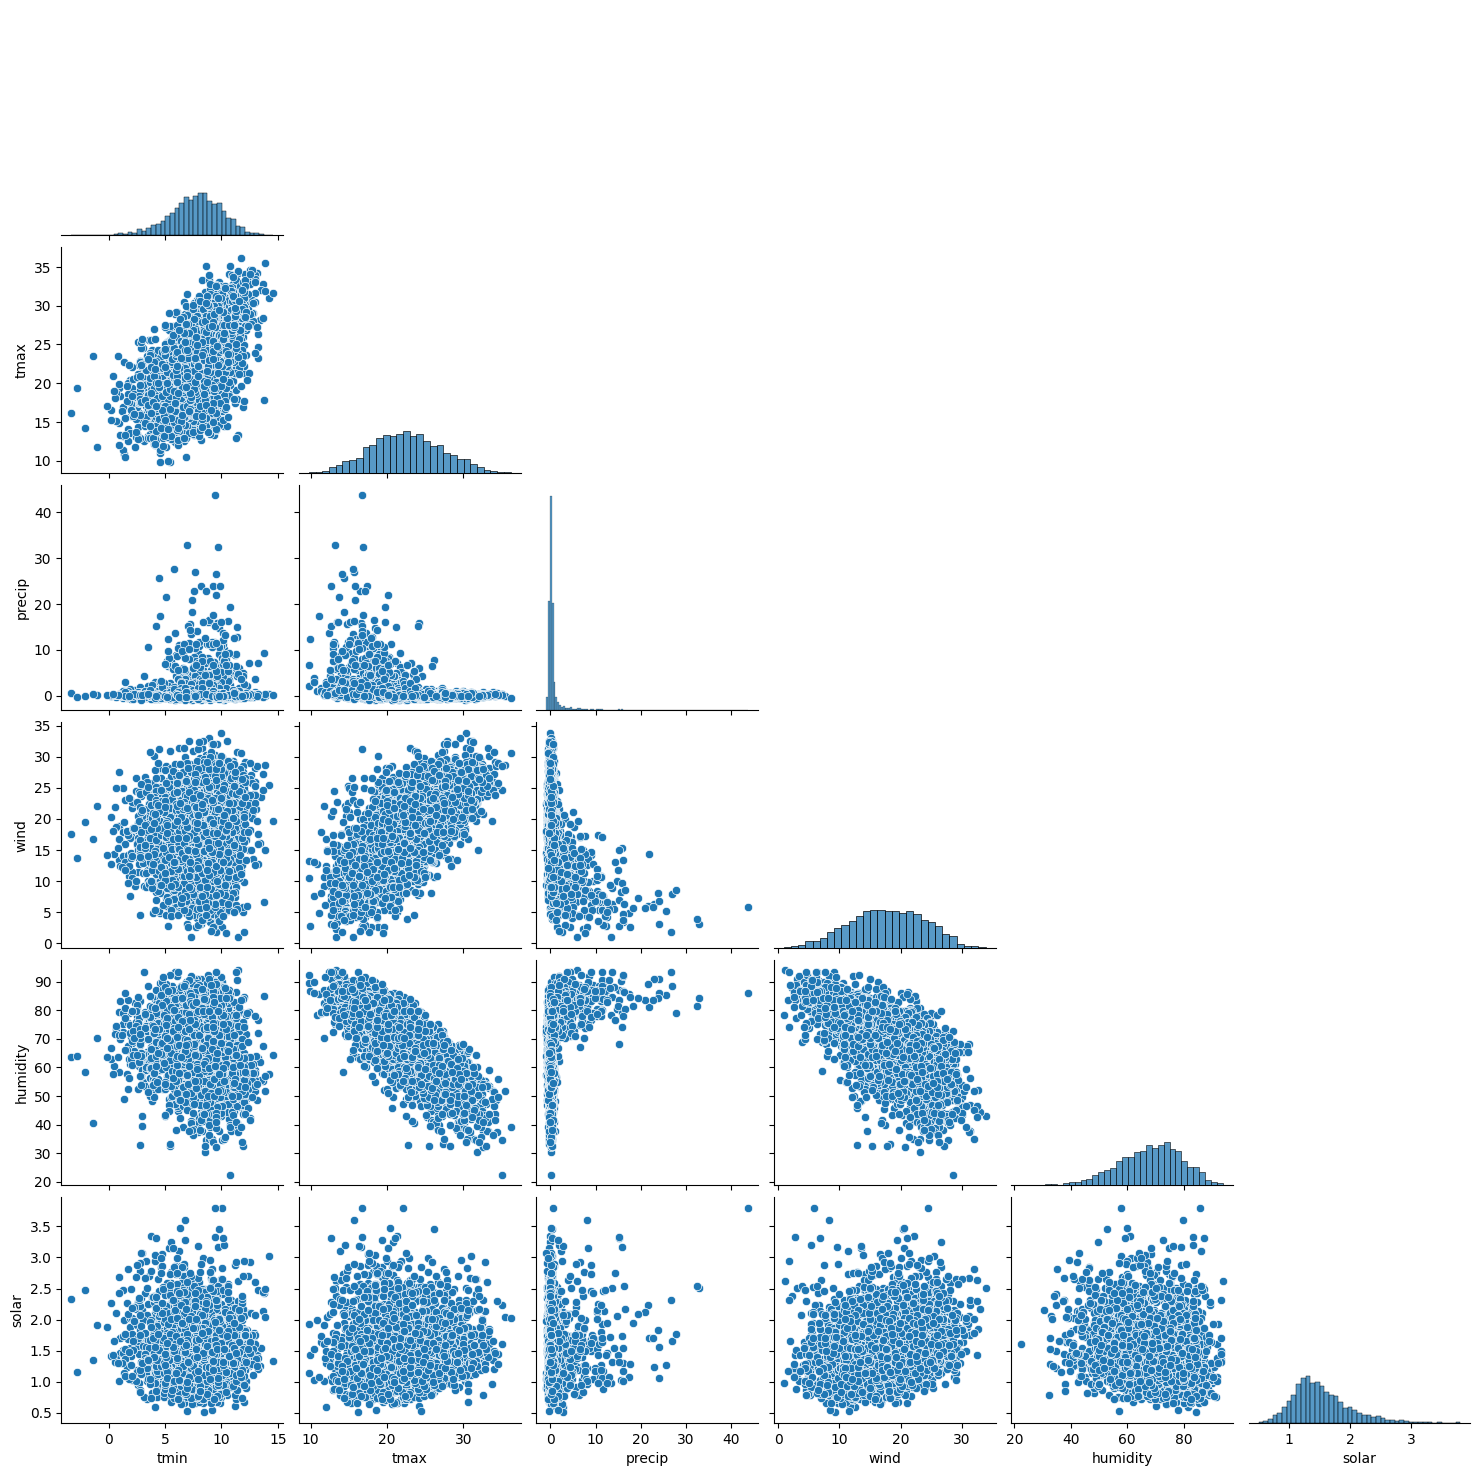

In [28]:
new_df = pd.DataFrame()
for i in range(Omega.shape[0]):
     new_df = pd.concat([new_df, pd.DataFrame(Omega[i], columns=var_names)], axis=0)

sns.pairplot(new_df, corner=True, diag_kind="hist")
plt.show()


In [29]:
new_df.corr()

,tmin,tmax,precip,wind,humidity,solar
tmin,1.000000,0.561253,0.075567,0.113866,-0.155341,-0.068839
tmax,0.561253,1.000000,-0.319040,0.681932,-0.777188,0.032036
precip,0.075567,-0.319040,1.000000,-0.397418,0.363839,0.101129
wind,0.113866,0.681932,-0.397418,1.000000,-0.660279,0.210198
humidity,-0.155341,-0.777188,0.363839,-0.660279,1.000000,-0.169516
solar,-0.068839,0.032036,0.101129,0.210198,-0.169516,1.000000


In [30]:
df.corr()

,tmin,tmax,precip,wind,humidity,solar
tmin,1.000000,0.281146,0.291034,-0.269809,0.452076,0.089735
tmax,0.281146,1.000000,-0.339060,0.417087,-0.520531,-0.084126
precip,0.291034,-0.339060,1.000000,-0.517465,0.502285,0.552233
wind,-0.269809,0.417087,-0.517465,1.000000,-0.485321,-0.156732
humidity,0.452076,-0.520531,0.502285,-0.485321,1.000000,0.191650
solar,0.089735,-0.084126,0.552233,-0.156732,0.191650,1.000000


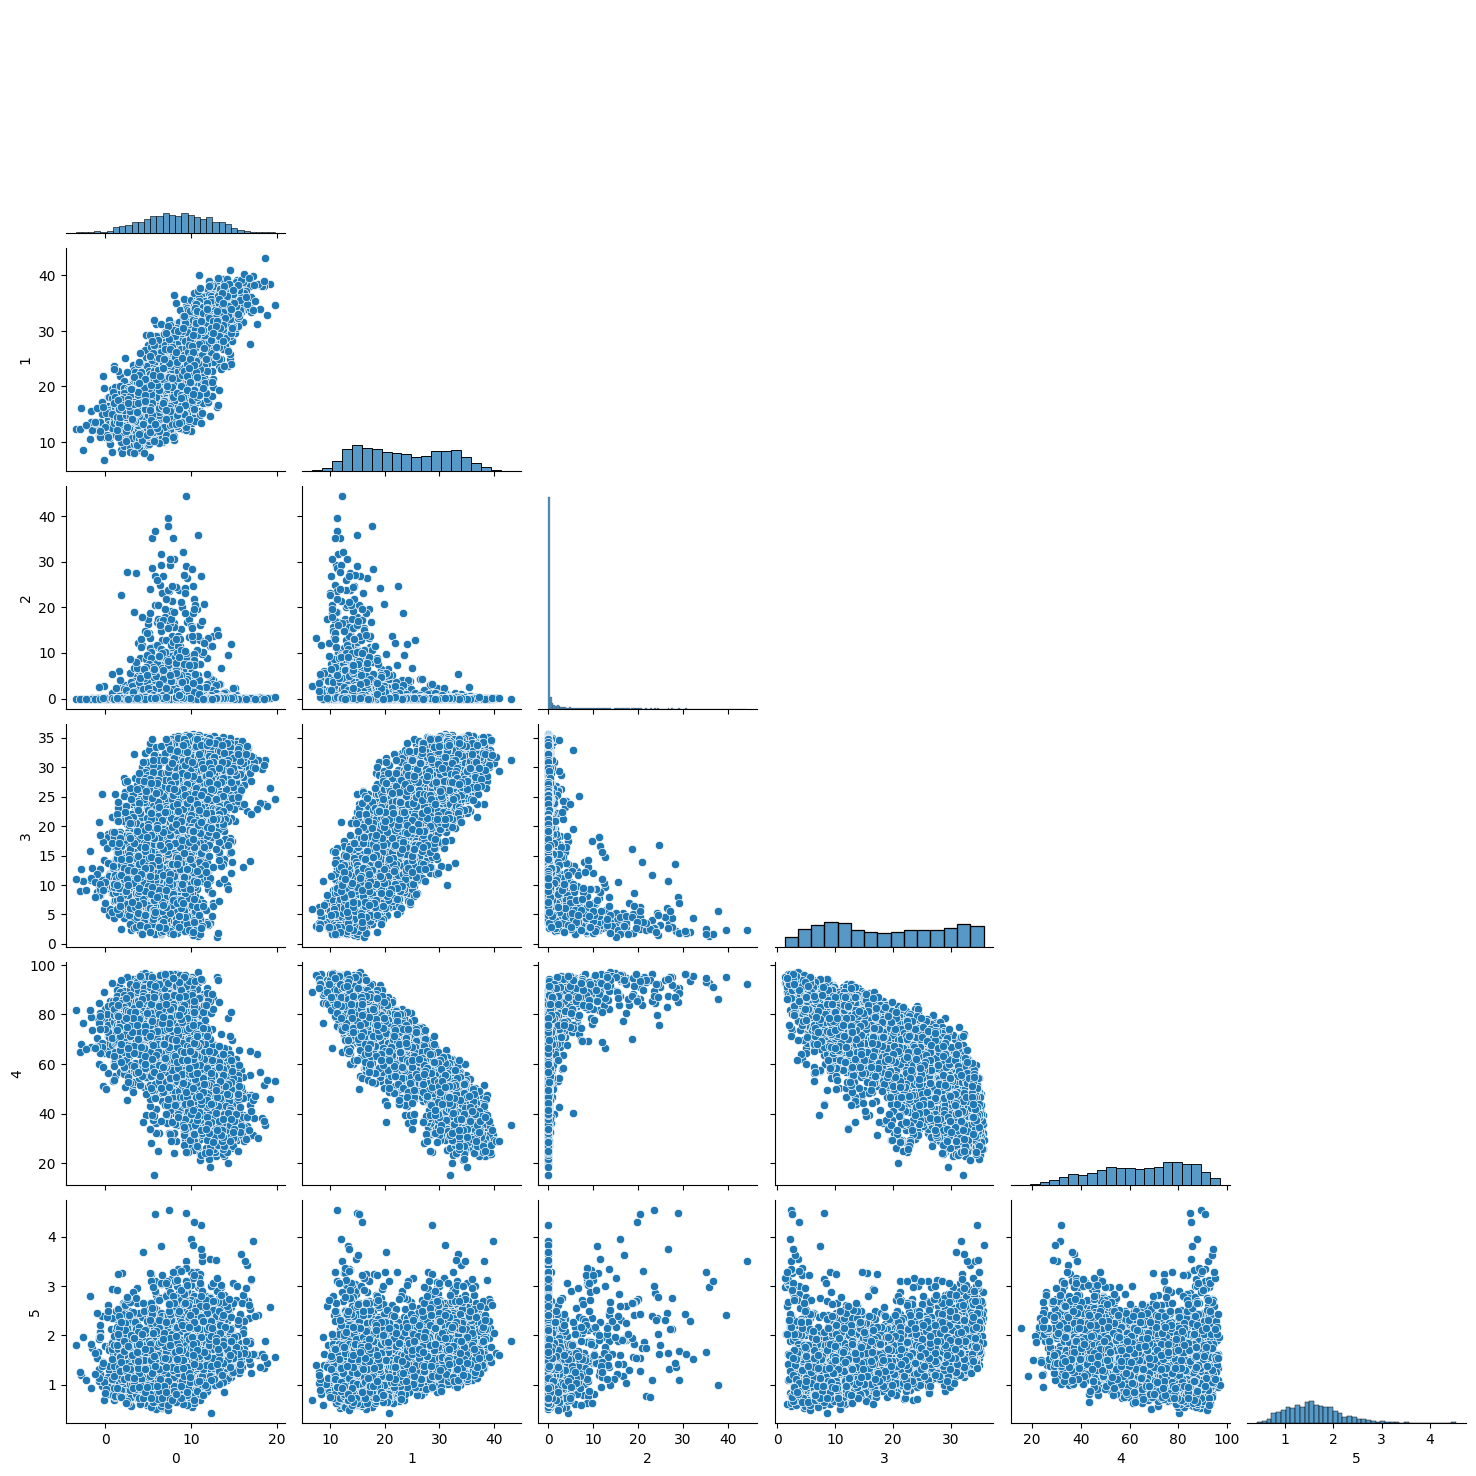

In [31]:
sns.pairplot(pd.DataFrame(X), corner=True, diag_kind="hist")
plt.show()

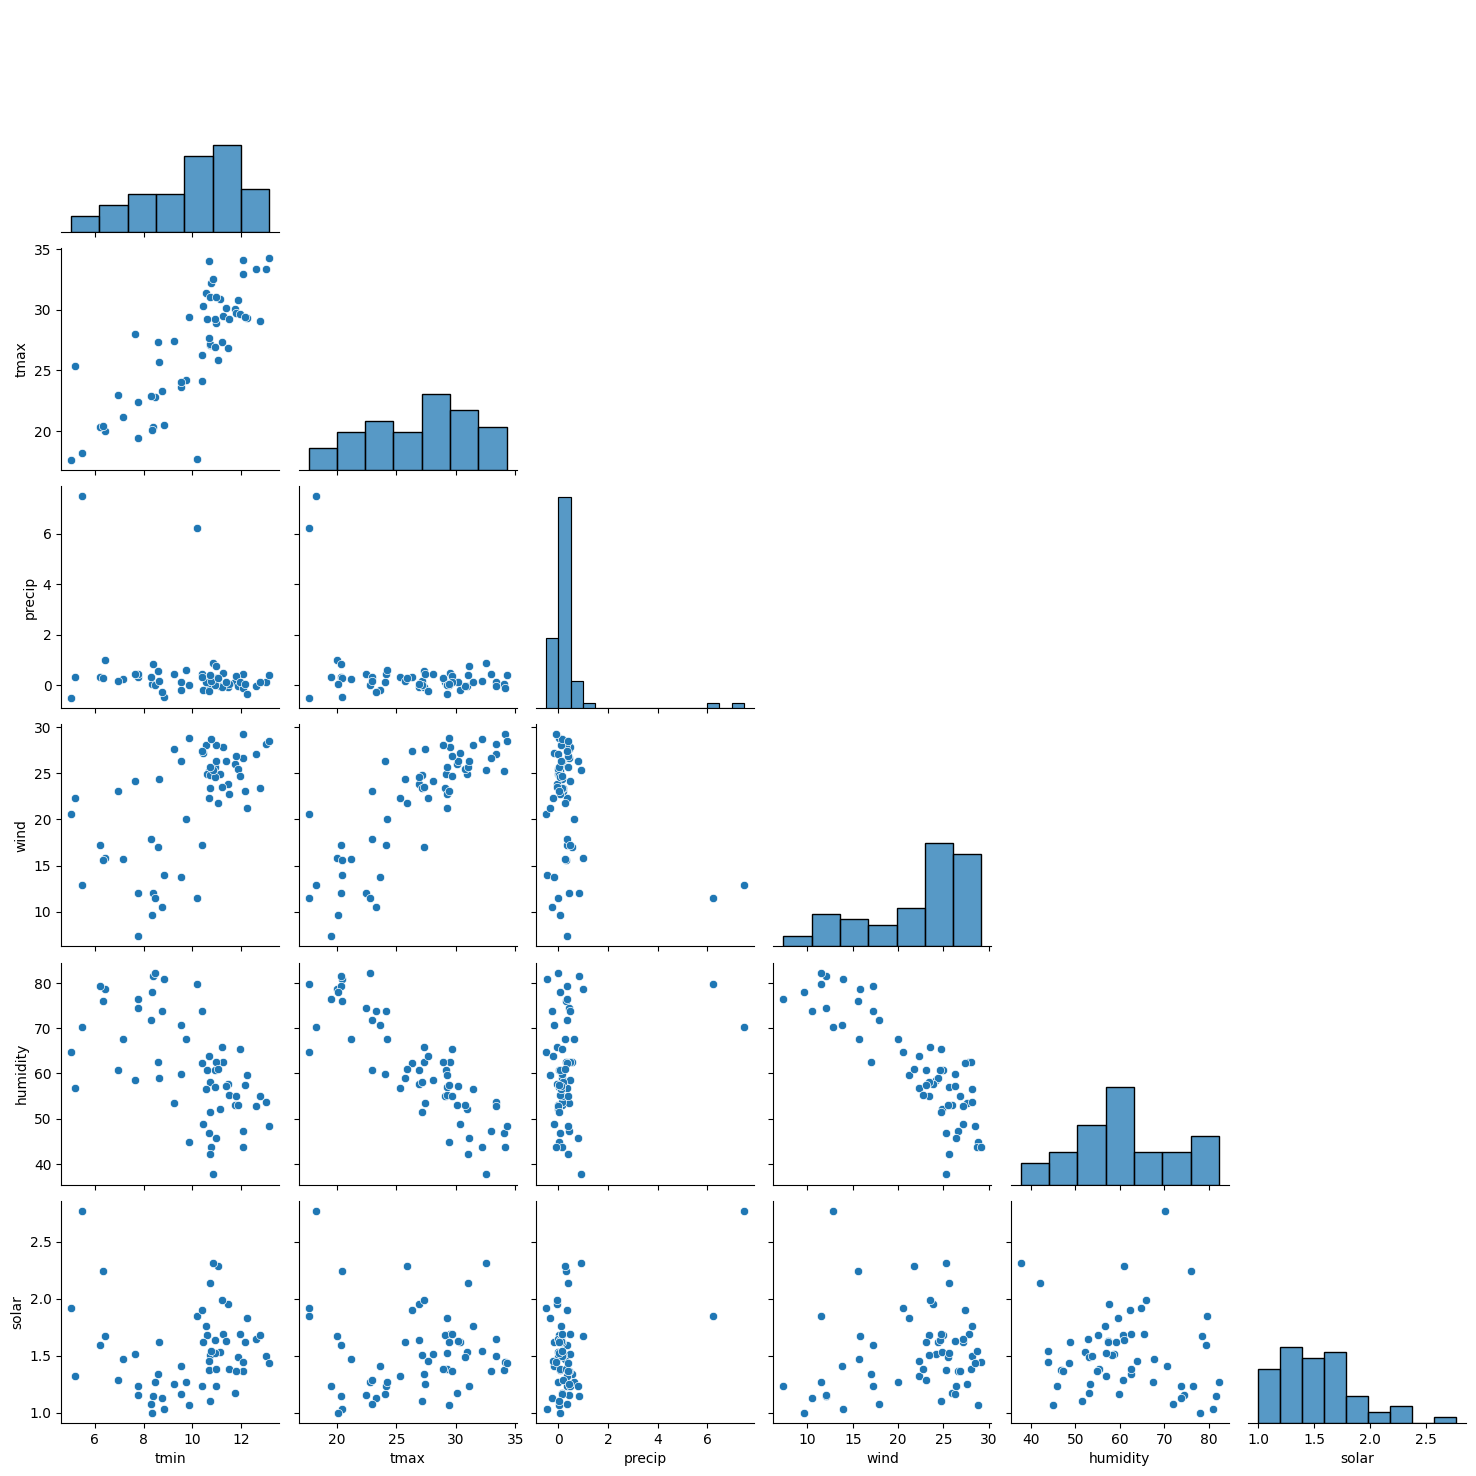

In [32]:
X_mean = Omega[0]   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()